In [ ]:
import os
import re
import jieba # 用于中文分词
from sentence_transformers import SentenceTransformer # 用于生成句向量
from bertopic import BERTopic
import pandas as pd # 用于处理数据和读取CSV

# —— 配置部分 —— #

input_data_dir = r"E:\step4"

output_save_dir = r"E:\step4_hierarchical"
os.makedirs(output_save_dir, exist_ok=True)

platforms = ['dy', 'xhs', 'tieba'] # 平台列表
comment_column = 'content' # 评论数据所在的列名

# 停用词 (来自用户)
STOPWORDS_PATH = "stopwords1893.txt" # 停用词文件路径
custom_stopwords = [
    "豆包", "DS", "下载", "文心", "百度", "一言", "内容", "东西",
    "偷笑", "感觉", "真的", "模型", "女套", "男套", "玫瑰", "捂脸",
    "哈哈", "排位", "正赛", "量子", "男鞋", "雷诺", "男裤", "永久",
    "哈", "哈哈哈", "哈哈哈哈",
]

# 加载停用词函数 
def load_chinese_stopwords(filepath, custom_list):
    """加载中文停用词表"""
    stopwords = set(custom_list)
    if os.path.isfile(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                w = line.strip()
                if w:
                    stopwords.add(w)
    else:
        print(f"警告：停用词文件未找到：{filepath}。将仅使用自定义停用词。")
    return stopwords

# 加载停用词实例
stop_words = load_chinese_stopwords(STOPWORDS_PATH, custom_stopwords)

# 文本预处理函数 (来自用户)
def preprocess_text(text, stop_words_set):
    """对文本进行预处理，包括去URL、去非中文字符、分词、去停用词"""
    if not isinstance(text, str):
        return []
    text = re.sub(r"http[s]?://\S+", "", text)
    text = re.sub(r"[^\u4e00-\u9fa5]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    if not text:
        return []
    words = jieba.lcut(text)
    return [w for w in words if w not in stop_words_set and len(w) > 1]

# 打印BERTopic主题词和权重函数 (来自用户)
def print_bertopic_top_words_with_weight(topic_model, n_words=10):
    """打印BERTopic模型每个主题的关键词及其权重"""
    topics = topic_model.get_topics()
    print("\n--- 主题关键词（带权重）---")
    print("主题号\t主题关键词（权重）")
    for tid, words_with_weights in sorted(topics.items()):
        if tid == -1:
            print(f"{tid}\t[离群点或噪声数据]")
            continue
        topic_str = "、".join([f"{w}({wt:.4f})" for w, wt in words_with_weights[:n_words]])
        print(f"{tid}\t{topic_str}")

# 为每个平台预设最优主题数 
best_k_dict = {
    "dy": 5,
    "xhs": 7,
    "tieba": 7
}

# 句向量模型 (来自用户)
embedding_model_name = "paraphrase-multilingual-MiniLM-L12-v2"
try:
    embedding_model = SentenceTransformer(embedding_model_name)
except Exception as e:
    print(f"加载 SentenceTransformer 模型失败: {e}")
    print("请确保已安装 sentence-transformers 并且可以连接到 Hugging Face Hub (如果模型需要下载)。")
    print("或者，提供本地模型路径。")
    exit()


for platform in platforms:
    print(f"\n{'='*20} 开始处理平台：{platform} {'='*20}")

    # 1. 构建CSV文件路径并加载数据
    csv_path = os.path.join(input_data_dir, f"{platform}_combined.csv") # 

    if not os.path.isfile(csv_path):
        print(f"文件不存在，跳过平台 {platform}：{csv_path}")
        continue

    try:
        print(f"正在从 {csv_path} 加载数据...")
        df = pd.read_csv(csv_path, encoding='utf-8') # 尝试utf-8，如果不行可能需要指定其他编码如'gbk'
        if comment_column not in df.columns:
            print(f"错误：列 '{comment_column}' 不在文件 {csv_path} 中。可用的列有: {df.columns.tolist()}")
            continue
        
        # 提取评论内容，并处理缺失值
        docs_for_platform = df[comment_column].dropna().astype(str).tolist()
        if not docs_for_platform:
            print(f"平台 {platform} 的 '{comment_column}' 列没有有效数据或全为空值。")
            continue
        print(f"为平台 {platform} 加载了 {len(docs_for_platform)} 条文档。")

    except Exception as e:
        print(f"加载或读取平台 {platform} 的CSV文件 {csv_path} 时出错: {e}")
        continue

    # 2. 文本预处理
    print(f"\n--- 针对平台 '{platform}' 进行文本预处理 ---")
    processed_documents = [" ".join(preprocess_text(doc, stop_words)) for doc in docs_for_platform]
    processed_documents = [doc for doc in processed_documents if doc.strip()] # 过滤空字符串
    
    if not processed_documents:
        print(f"平台 '{platform}' 经过预处理后没有有效的文档进行主题建模。")
        continue
    print(f"预处理后有效文档数量: {len(processed_documents)}")

    # 3. BERTopic 模型初始化与训练
    print("\n--- 步骤1: 训练BERTopic模型以获取初始主题 ---")
    topic_model = BERTopic(
        embedding_model=embedding_model,
        language="chinese",
        min_topic_size=3, # 调整此值以获得合适的初始主题数量，可以尝试3, 5, 10等
        verbose=True
    )

    try:
        topics, probabilities = topic_model.fit_transform(processed_documents)
    except Exception as e:
        print(f"在平台 {platform} 上训练BERTopic模型失败: {e}")
        print("可能原因：文档数量过少，或所有文档向量非常相似。尝试调整min_topic_size或检查数据。")
        continue

    print(f"\n平台 '{platform}' 初始发现的主题数量 (包括离群点主题-1): {len(topic_model.get_topic_freq())}")
    if not topic_model.get_topics() or len(topic_model.get_topic_freq()) <=1 : # <=1 表示可能只有离群点
        print(f"平台 '{platform}'未能有效生成主题，跳过后续层次分析。")
        continue
        
    print_bertopic_top_words_with_weight(topic_model, n_words=7)

    # 4. 执行层次聚类分析
    print("\n--- 步骤2: 执行层次聚类分析 ---")
    try:
        hierarchical_topics_df = topic_model.hierarchical_topics(docs=processed_documents)
        if hierarchical_topics_df is None or hierarchical_topics_df.empty:
            print(f"平台 '{platform}' 未能生成层次主题DataFrame。可能是初始主题太少或结构不明显。")
        else:
            print("\n层次化主题结构 (DataFrame摘要):")
            print(hierarchical_topics_df.head())

            # 5. 可视化层次结构
            print("\n--- 步骤3: 可视化层次主题结构 ---")
            # 动态确定可视化时希望看到的聚合主题簇的数量
            default_hier_topics = best_k_dict.get(platform, 5) # 从字典获取，若无则默认5
            num_visual_hier_topics = default_hier_topics  # 示例：平台k的两倍加3
            
            # 确保请求的主题数不超过实际可用主题数（减去离群点主题）
            actual_base_topics_count = len(topic_model.get_topic_freq()) -1 
            if actual_base_topics_count <= 0: # 没有有效的基础主题
                print(f"平台 '{platform}' 没有足够的基础主题进行有意义的层次可视化。")
            else:
                num_visual_hier_topics = min(num_visual_hier_topics, actual_base_topics_count)
                num_visual_hier_topics = max(2, num_visual_hier_topics) # 至少可视化2个主题

                print(f"尝试在 '{platform}' 的层次可视化中展示大约 {num_visual_hier_topics} 个聚合主题。")
                
                fig_hierarchy = topic_model.visualize_hierarchy(
                    hierarchical_topics=hierarchical_topics_df,
                    top_n_topics=min(50, actual_base_topics_count) 
                )
                
                hierarchy_plot_path = os.path.join(output_save_dir, f"{platform}_hierarchical_plot_k{num_visual_hier_topics}.html")
                fig_hierarchy.write_html(hierarchy_plot_path)
                print(f"平台 '{platform}' 的层次主题关系图已保存到: {hierarchy_plot_path}")

                # 6. (可选) 根据层次结构规约主题数量到特定k值并查看信息
                target_k = best_k_dict.get(platform, 5)
                target_k = min(target_k, actual_base_topics_count) # 确保不超过实际基础主题
                target_k = max(1, target_k) # 至少为1

                print(f"\n--- 步骤4 (可选): 查看在层次结构中聚合到 {target_k} 个主题时的代表词 ---")
                if actual_base_topics_count > 0:
                    try:
                        topics_info_at_k = topic_model.get_topic_info(custom_labels=True, nr_topics=target_k, hierarchical_topics=hierarchical_topics_df)
                        print(f"当层次聚合到 {target_k} 个主题时 (基于custom_labels):")
                        print(topics_info_at_k[['Topic', 'CustomName', 'Count']].head(target_k + 1)) 
                    except TypeError: 
                        print(f"注意：当前BERTopic版本可能不支持直接从get_topic_info获取指定数量的层级主题。层次图是主要输出。")
                    except Exception as e_info:
                         print(f"获取 {target_k} 个主题信息时出错: {e_info}")
                else:
                    print(f"平台 '{platform}' 没有足够的基础主题来获取 {target_k} 个主题的信息。")


    except Exception as e:
        print(f"为平台 '{platform}' 生成或可视化层次主题时发生主要错误: {e}")
        print("这可能是因为初始主题数量过少。尝试调整 BERTopic 的 min_topic_size 参数或检查输入数据。")

    print(f"\n{'='*20} 完成平台：{platform} {'='*20}")

print(f"\n--- 所有平台处理完成。结果保存在: {output_save_dir} ---")


==================== 开始处理平台：dy ====================
正在从 E:\统计建模大赛\情感介绍\step4\dy_combined.csv 加载数据...
为平台 dy 加载了 22213 条文档。

--- 针对平台 'dy' 进行文本预处理 ---


2025-05-30 20:35:59,437 - BERTopic - Embedding - Transforming documents to embeddings.


预处理后有效文档数量: 18159

--- 步骤1: 训练BERTopic模型以获取初始主题 ---


Batches:   0%|          | 0/568 [00:00<?, ?it/s]

2025-05-30 20:36:33,386 - BERTopic - Embedding - Completed ✓
2025-05-30 20:36:33,387 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-30 20:36:37,315 - BERTopic - Dimensionality - Completed ✓
2025-05-30 20:36:37,317 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-30 20:36:39,407 - BERTopic - Cluster - Completed ✓
2025-05-30 20:36:39,413 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-30 20:36:39,857 - BERTopic - Representation - Completed ✓



平台 'dy' 初始发现的主题数量 (包括离群点主题-1): 1283

--- 主题关键词（带权重）---
主题号	主题关键词（权重）
-1	[离群点或噪声数据]
0	好用(0.1077)、好使(0.0876)、好话(0.0402)、干净(0.0156)、有趣(0.0119)、好看(0.0067)、准确(0.0061)
1	谢谢(0.0462)、感谢(0.0347)、高姐(0.0346)、祖宗(0.0330)、八辈(0.0330)、开导(0.0255)、感谢您(0.0250)
2	软件(0.0424)、委屈(0.0265)、此类(0.0259)、吉林(0.0259)、画图(0.0222)、很早(0.0206)、减少(0.0176)
3	免费(0.0636)、全免费(0.0275)、打算(0.0249)、音乐(0.0203)、水平(0.0115)、(0.0000)、(0.0000)
4	技术(0.0602)、科技(0.0531)、发家(0.0245)、军工(0.0245)、高科技(0.0222)、核心(0.0217)、政策(0.0216)
5	确实(0.1429)、我信(0.1277)、言过其实(0.0605)、陈冠希(0.0605)、有没有(0.0118)、(0.0000)、(0.0000)
6	收费(0.1228)、生成(0.0058)、(0.0000)、(0.0000)、(0.0000)、(0.0000)、(0.0000)
7	广告(0.0907)、独特(0.0879)、清一色(0.0500)、男科(0.0398)、背景(0.0260)、宣传(0.0184)、包装(0.0165)
8	算命(0.3286)、上当(0.1414)、面相(0.1185)、功劳(0.0717)、上生(0.0717)、拿命(0.0592)、亏了(0.0592)
9	调成(0.0860)、稳住(0.0842)、卡着(0.0842)、绷住(0.0740)、碰到(0.0670)、碾压(0.0573)、一把抓(0.0509)
10	名字(0.1183)、昵称(0.0871)、英文名(0.0545)、记不清(0.0509)、绰号(0.0509)、英文名字(0.0468)、含义(0.0426)
11	不用(0.1066)、不花(0.0605)、没话(0.0605)、不儿(0.0500)、拒绝(0

100%|██████████| 1281/1281 [00:04<00:00, 312.20it/s]



层次化主题结构 (DataFrame摘要):
     Parent_ID     Parent_Name  \
1280      2562  不错_满意_好用_真心_值得   
1279      2561  不错_满意_好用_真心_值得   
1278      2560  不错_满意_好用_真心_值得   
1277      2559  不错_满意_好用_真心_值得   
1276      2558  不错_满意_好用_真心_值得   

                                                 Topics Child_Left_ID  \
1280  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          1433   
1279  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          2560   
1278  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          1321   
1277  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          2558   
1276  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          2514   

       Child_Left_Name Child_Right_ID Child_Right_Name  Distance  
1280    黑脸_黑化_发黑_印堂_王刚           2561   不错_满意_好用_真心_值得  2.440077  
1279    不错_满意_好用_真心_值得           1335   治愈_记到_深深_渴望_智慧  1.898705  
1278   鼓掌_赞赞_抱抱_办不到_掌声           2559   不错_满意_好用_真心_值得  1.862295  
1277    不错_满意_好用_真心_值得           1432   拍照_搜题_识题_答疑_拍图  1.838007

2025-05-30 20:36:48,447 - BERTopic - Embedding - Transforming documents to embeddings.


预处理后有效文档数量: 35183

--- 步骤1: 训练BERTopic模型以获取初始主题 ---


Batches:   0%|          | 0/1100 [00:00<?, ?it/s]

2025-05-30 20:38:11,536 - BERTopic - Embedding - Completed ✓
2025-05-30 20:38:11,537 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-30 20:38:18,831 - BERTopic - Dimensionality - Completed ✓
2025-05-30 20:38:18,832 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-30 20:38:20,407 - BERTopic - Cluster - Completed ✓
2025-05-30 20:38:20,416 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-30 20:38:21,259 - BERTopic - Representation - Completed ✓



平台 'xhs' 初始发现的主题数量 (包括离群点主题-1): 2100

--- 主题关键词（带权重）---
主题号	主题关键词（权重）
-1	[离群点或噪声数据]
0	失望(0.0359)、总给(0.0098)、包围(0.0091)、易如反掌(0.0091)、鸿蒙(0.0089)、失败(0.0075)、我行(0.0070)
1	数据(0.0291)、统计(0.0132)、原始数据(0.0101)、数据分析(0.0101)、来源(0.0081)、数据表(0.0076)、清高(0.0076)
2	中国(0.0368)、进口(0.0136)、公民(0.0118)、加拿大(0.0110)、日本(0.0101)、华裔(0.0097)、家属(0.0097)
3	好用(0.1087)、好使(0.0299)、好帮手(0.0254)、(0.0000)、(0.0000)、(0.0000)、(0.0000)
4	小红书(0.0715)、发小红书(0.0193)、来小红书(0.0144)、没小红书(0.0144)、小红(0.0144)、女生(0.0137)、用小红书(0.0129)
5	记忆(0.0589)、记忆力(0.0400)、失忆(0.0285)、记性(0.0275)、健忘症(0.0246)、再传(0.0201)、每提(0.0201)
6	名字(0.0646)、改名(0.0425)、光听(0.0293)、起得(0.0269)、改名字(0.0219)、小名(0.0219)、命名(0.0219)
7	点错(0.0415)、两个(0.0393)、他俩(0.0365)、第二张(0.0293)、底座(0.0223)、第二个(0.0216)、妙笔(0.0195)
8	出新(0.0306)、韭菜(0.0252)、先免(0.0221)、最多算(0.0221)、后付费(0.0221)、免费(0.0204)、钱袋(0.0203)
9	元宝(0.0430)、宝藏(0.0422)、宝石(0.0345)、鎏金(0.0316)、阉割(0.0182)、母贝(0.0152)、抽红(0.0152)
10	中文(0.0498)、翻译成(0.0234)、中文版(0.0232)、汉语言(0.0232)、英文(0.0218)、粤语(0.0216)、汉字(0.0203)
11	黄金(0.1487)、尸块(0.0381)、

100%|██████████| 2098/2098 [00:08<00:00, 233.83it/s]



层次化主题结构 (DataFrame摘要):
     Parent_ID      Parent_Name  \
2097      4196  小红书_分享_飞吻_黄金_失望   
2096      4195  小红书_黄金_失望_派对_垃圾   
2095      4194  小红书_黄金_失望_派对_垃圾   
2094      4193  小红书_黄金_失望_派对_垃圾   
2093      4192  小红书_黄金_失望_派对_垃圾   

                                                 Topics Child_Left_ID  \
2097  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          4187   
2096  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          4194   
2095  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          4193   
2094  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          2294   
2093  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          4157   

         Child_Left_Name Child_Right_ID Child_Right_Name  Distance  
2097     感谢_谢谢_飞吻_分享_宝子们           4195  小红书_黄金_失望_派对_垃圾  2.172552  
2096     小红书_黄金_失望_派对_垃圾           2915   消息_我下_招呼_吧唧_搏斗  2.104610  
2095     小红书_黄金_失望_派对_垃圾           3058   微笑_各打_大板_五十_鼻子  2.045577  
2094  大笑_笑掉大牙_笑哈哈_最清奇_配文           4192  小红书_黄金_失望

2025-05-30 20:38:35,840 - BERTopic - Embedding - Transforming documents to embeddings.


预处理后有效文档数量: 13751

--- 步骤1: 训练BERTopic模型以获取初始主题 ---


Batches:   0%|          | 0/430 [00:00<?, ?it/s]

2025-05-30 20:39:15,535 - BERTopic - Embedding - Completed ✓
2025-05-30 20:39:15,536 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-30 20:39:18,430 - BERTopic - Dimensionality - Completed ✓
2025-05-30 20:39:18,431 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-30 20:39:19,018 - BERTopic - Cluster - Completed ✓
2025-05-30 20:39:19,023 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-30 20:39:19,504 - BERTopic - Representation - Completed ✓



平台 'tieba' 初始发现的主题数量 (包括离群点主题-1): 1117

--- 主题关键词（带权重）---
主题号	主题关键词（权重）
-1	[离群点或噪声数据]
0	日本(0.0817)、日语(0.0532)、大阪(0.0389)、词汇(0.0287)、汉语(0.0277)、西方(0.0255)、起源于(0.0239)
1	老哥(0.1799)、暴躁(0.0607)、老洛放(0.0579)、老洛是(0.0579)、老美(0.0505)、老爷爷(0.0426)、背来(0.0426)
2	硅基(0.1268)、流动(0.1037)、按键(0.0496)、秘钥(0.0358)、虚拟(0.0264)、充过(0.0247)、硅基有(0.0247)
3	打不开(0.1187)、川普(0.0623)、别太爱(0.0623)、别串(0.0459)、别气(0.0459)、没翻(0.0459)、别用(0.0420)
4	内存(0.0375)、上文(0.0355)、回忆(0.0322)、记忆(0.0301)、越长(0.0259)、进新(0.0258)、第五句(0.0258)
5	算过(0.2183)、不准(0.1647)、算了(0.0812)、无甲(0.0742)、九尾(0.0728)、行不行(0.0559)、初审(0.0476)
6	助手(0.1390)、吃光(0.0760)、跑得快(0.0586)、文小言(0.0532)、幸亏(0.0439)、助理(0.0427)、这么久(0.0416)
7	第三颗(0.2070)、纽扣(0.1982)、闲来无事(0.1465)、蹦出来(0.1160)、不住(0.1110)、大人(0.1067)、一股(0.0938)
8	不见得(0.2656)、不行(0.2281)、错过(0.1575)、不该(0.1383)、买不到(0.1226)、不想(0.0988)、连不上(0.0885)
9	可爱(0.6228)、阿梓(0.1106)、这组图(0.0943)、这不比(0.0943)、真帅(0.0811)、爱丽丝(0.0735)、奈子(0.0681)
10	攻击力(0.3702)、攻击(0.1371)、太强(0.0816)、强得(0.0780)、没边(0.0643)、间谍(0.0501)、自导自演(0.0501)
11	感谢(0.2912)、谢谢(0

100%|██████████| 1115/1115 [00:03<00:00, 316.79it/s]



层次化主题结构 (DataFrame摘要):
     Parent_ID     Parent_Name  \
1114      2230  评分_神龙_摆尾_专业_听众   
1113      2229  评分_神龙_摆尾_专业_听众   
1112      2228  定金_手机_谷歌_润到_交了   
1111      2227  评分_神龙_摆尾_专业_听众   
1110      2226  评分_神龙_摆尾_专业_听众   

                                                 Topics Child_Left_ID  \
1114  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...          2182   
1113  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...          2228   
1112  [58, 160, 184, 239, 286, 357, 433, 521, 541, 5...          1125   
1111  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...          2226   
1110  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...          1771   

         Child_Left_Name Child_Right_ID Child_Right_Name  Distance  
1114  感谢_谢谢_原来如此_多谢_非常感谢           2229   评分_神龙_摆尾_专业_听众  1.770673  
1113      定金_手机_谷歌_润到_交了           2227   评分_神龙_摆尾_专业_听众  1.675153  
1112     定金_润到_交了_白名单_咸鱼           2225   手机_谷歌_充电_账号_红米  1.660217  
1111      评分_神龙_摆尾_专业_听众           1129  腾讯_元宝_轻松_没关系_无甲

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import numpy as np
from umap import UMAP
from hdbscan import HDBSCAN
import requests
import re


In [14]:
### 1. 读取你的CSV数据
csv_path = "xhs_combined.csv" 
df = pd.read_csv(csv_path)
docs = df['content'].dropna().tolist()

### 2. 向量化文本
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

### 3. 降维&聚类模型
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### 4. Ollama LLM 接口
class OllamaLLM:
    def __init__(self, model_name="qwen3:4b"):
        self.url = "http://localhost:11434/api/generate"
        self.model_name = model_name

    def __call__(self, prompt):
        data = {
            "model": self.model_name,
            "prompt": prompt,
            "stream": False
        }
        try:
            response = requests.post(self.url, json=data, timeout=60)
            result = response.json()
            return result['response'].strip()
        except Exception as e:
            print("Ollama API error:", e)
            return ""

### 5. 定义主题自动label的prompt
prompt_template = """Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

### 6. 封装为BERTopic自定义label函数
from bertopic.representation._base import BaseRepresentation

class OllamaLabel(BaseRepresentation):
    def __init__(self, ollama_llm, prompt_template):
        self.ollama_llm = ollama_llm
        self.prompt_template = prompt_template

    def __call__(self, docs, c_tf_idf=None, words=None, **kwargs):
        # docs: 主题下的文本
        # words: 主题关键词列表
        keywords = ', '.join(words) if words else ''
        # 只取最多50个文档
        short_docs = "\n".join(docs[:50])
        prompt = self.prompt_template.replace("[DOCUMENTS]", short_docs).replace("[KEYWORDS]", keywords)
        label = self.ollama_llm(prompt)
        # 只保留首行且去掉特殊字符
        label = re.sub(r'\W+', ' ', label.split('\n')[0]).strip()
        return label if label else "Unlabelled"

representation_model = {"LLM": OllamaLabel(OllamaLLM("qwen3:4b"), prompt_template)}

### 7. 创建并拟合BERTopic模型

from sklearn.feature_extraction.text import CountVectorizer

# 停用词可以用sklearn自带的，也可以自己加
my_stopwords = [
    "哭惹r", "汗颜r", "捂脸r", "流汗r", "偷笑r", "哈哈", "哈哈哈", "哈哈哈哈"]

vectorizer_model = CountVectorizer(
    stop_words=my_stopwords,  # 直接传递停用词列表
    ngram_range=(1, 2),
    max_features=10000
)

# 然后创建 BERTopic 时加入 vectorizer_model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    vectorizer_model=vectorizer_model,  # 这里加入！
    top_n_words=10,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings)

### 8. 可选：二维降维用于可视化
umap_2d = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_2d.fit_transform(embeddings)

### 9. 主题标签整理
llm_labels = topic_model.topic_labels_
all_labels = [llm_labels[topic] if topic != -1 else "Unlabelled" for topic in topics]

Batches:   0%|          | 0/1214 [00:00<?, ?it/s]

2025-05-31 15:27:30,572 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-31 15:30:15,456 - BERTopic - Dimensionality - Completed ✓
2025-05-31 15:30:15,462 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-31 15:30:20,744 - BERTopic - Cluster - Completed ✓
2025-05-31 15:30:20,774 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-31 15:30:22,960 - BERTopic - Representation - Completed ✓


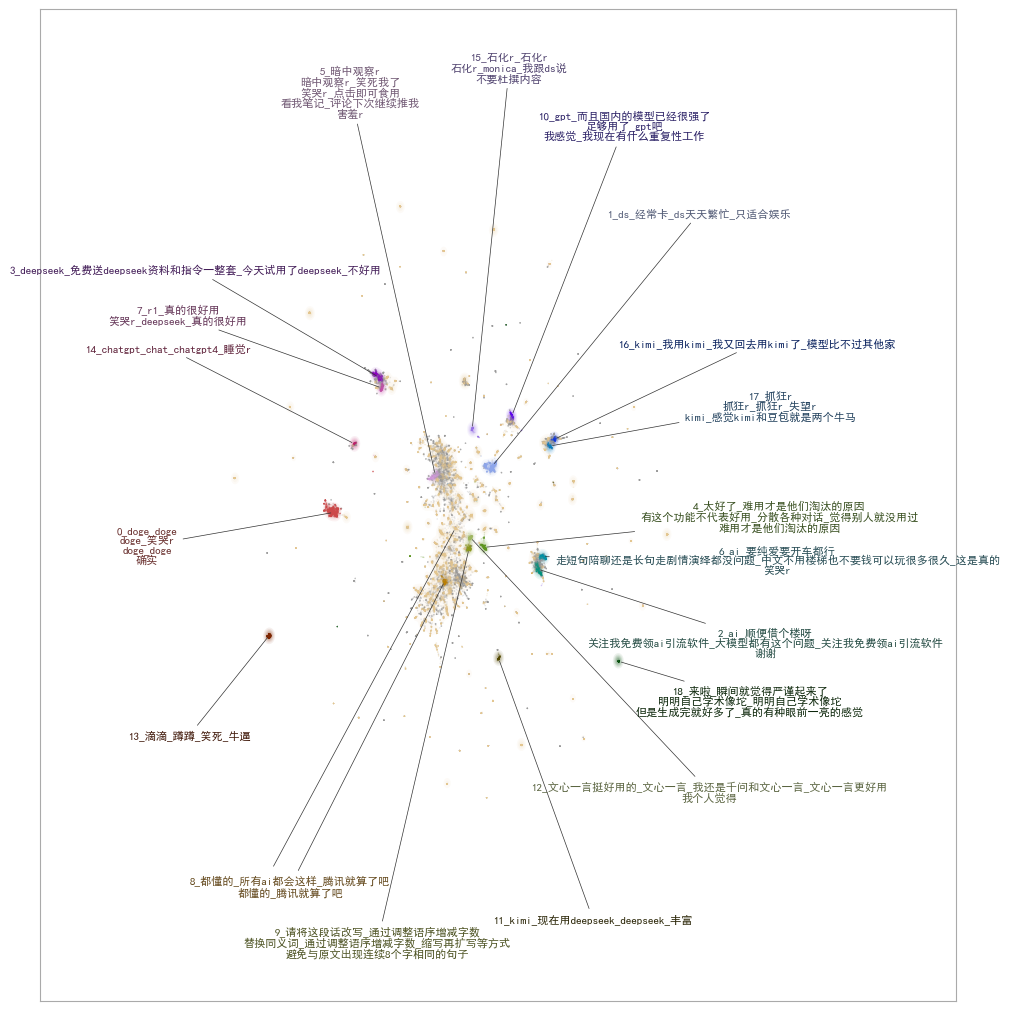

In [15]:
import datamapplot
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Source Han Sans SC']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

topic_counts = Counter(topics)
top_n = 20
top_topics = [t for t, _ in topic_counts.most_common(top_n)]
plot_labels = [
    all_labels[i] if topics[i] in top_topics else ''
    for i in range(len(all_labels))
]

# 创建图像并获取 Figure 对象
fig, ax = datamapplot.create_plot(
    reduced_embeddings,
    plot_labels,
    label_font_size=8,
    label_wrap_width=9,
    use_medoids=True,
    logo=None,
    logo_width=0.16,
    font_family="SimHei"
)
fig.savefig("topic_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)


In [2]:
### 1. 读取你的CSV数据
csv_path = "dy_combined.csv" 
df = pd.read_csv(csv_path)
docs = df['content'].dropna().tolist()

### 2. 向量化文本
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

### 3. 降维&聚类模型
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### 4. Ollama LLM 接口
class OllamaLLM:
    def __init__(self, model_name="qwen3:4b"):
        self.url = "http://localhost:11434/api/generate"
        self.model_name = model_name

    def __call__(self, prompt):
        data = {
            "model": self.model_name,
            "prompt": prompt,
            "stream": False
        }
        try:
            response = requests.post(self.url, json=data, timeout=60)
            result = response.json()
            return result['response'].strip()
        except Exception as e:
            print("Ollama API error:", e)
            return ""

### 5. 定义主题自动label的prompt
prompt_template = """Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

### 6. 封装为BERTopic自定义label函数
from bertopic.representation._base import BaseRepresentation

class OllamaLabel(BaseRepresentation):
    def __init__(self, ollama_llm, prompt_template):
        self.ollama_llm = ollama_llm
        self.prompt_template = prompt_template

    def __call__(self, docs, c_tf_idf=None, words=None, **kwargs):
        # docs: 主题下的文本
        # words: 主题关键词列表
        keywords = ', '.join(words) if words else ''
        # 只取最多50个文档
        short_docs = "\n".join(docs[:50])
        prompt = self.prompt_template.replace("[DOCUMENTS]", short_docs).replace("[KEYWORDS]", keywords)
        label = self.ollama_llm(prompt)
        # 只保留首行且去掉特殊字符
        label = re.sub(r'\W+', ' ', label.split('\n')[0]).strip()
        return label if label else "Unlabelled"

representation_model = {"LLM": OllamaLabel(OllamaLLM("qwen3:4b"), prompt_template)}

### 7. 创建并拟合BERTopic模型

from sklearn.feature_extraction.text import CountVectorizer

# 停用词可以用sklearn自带的，也可以自己加
my_stopwords = [
    "哭惹r", "汗颜r", "捂脸r", "流汗r", "偷笑r", "哈哈", "哈哈哈", "哈哈哈哈"]

vectorizer_model = CountVectorizer(
    stop_words=my_stopwords,  # 直接传递停用词列表
    ngram_range=(1, 2),
    max_features=10000
)

# 然后创建 BERTopic 时加入 vectorizer_model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    vectorizer_model=vectorizer_model,  # 这里加入！
    top_n_words=10,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings)

### 8. 可选：二维降维用于可视化
umap_2d = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_2d.fit_transform(embeddings)

### 9. 主题标签整理
llm_labels = topic_model.topic_labels_
all_labels = [llm_labels[topic] if topic != -1 else "Unlabelled" for topic in topics]

Batches:   0%|          | 0/695 [00:00<?, ?it/s]

2025-06-03 15:20:10,920 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-03 15:20:39,957 - BERTopic - Dimensionality - Completed ✓
2025-06-03 15:20:39,957 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-03 15:20:41,754 - BERTopic - Cluster - Completed ✓
2025-06-03 15:20:41,762 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-03 15:20:41,958 - BERTopic - Representation - Completed ✓


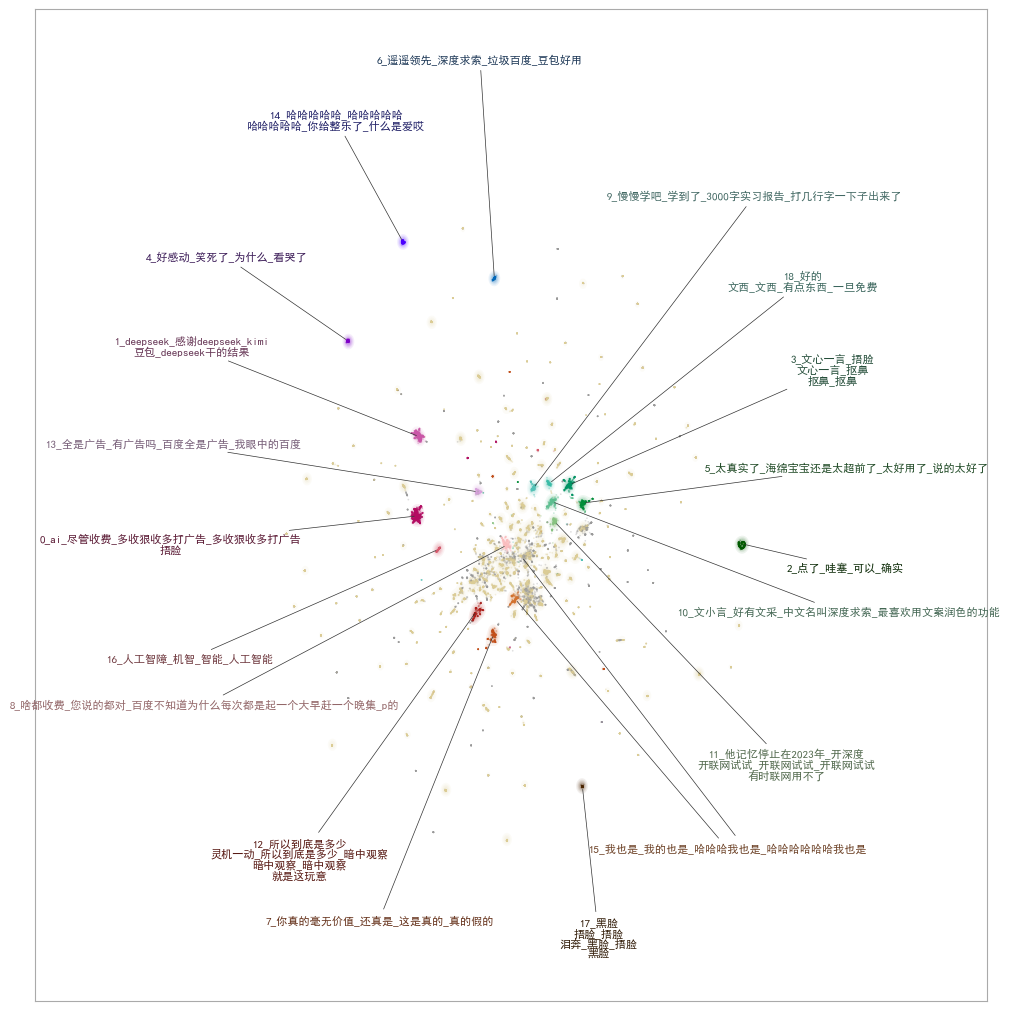

In [3]:
import datamapplot
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Source Han Sans SC']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

topic_counts = Counter(topics)
top_n = 20
top_topics = [t for t, _ in topic_counts.most_common(top_n)]
plot_labels = [
    all_labels[i] if topics[i] in top_topics else ''
    for i in range(len(all_labels))
]

# 创建图像并获取 Figure 对象
fig, ax = datamapplot.create_plot(
    reduced_embeddings,
    plot_labels,
    label_font_size=8,
    label_wrap_width=9,
    use_medoids=True,
    logo=None,
    logo_width=0.16,
    font_family="SimHei"
)
fig.savefig("dy_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)


In [4]:
### 1. 读取你的CSV数据
csv_path = "tieba_combined.csv" 
df = pd.read_csv(csv_path)
docs = df['content'].dropna().tolist()

### 2. 向量化文本
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

### 3. 降维&聚类模型
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### 4. Ollama LLM 接口
class OllamaLLM:
    def __init__(self, model_name="qwen3:4b"):
        self.url = "http://localhost:11434/api/generate"
        self.model_name = model_name

    def __call__(self, prompt):
        data = {
            "model": self.model_name,
            "prompt": prompt,
            "stream": False
        }
        try:
            response = requests.post(self.url, json=data, timeout=60)
            result = response.json()
            return result['response'].strip()
        except Exception as e:
            print("Ollama API error:", e)
            return ""

### 5. 定义主题自动label的prompt
prompt_template = """Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

### 6. 封装为BERTopic自定义label函数
from bertopic.representation._base import BaseRepresentation

class OllamaLabel(BaseRepresentation):
    def __init__(self, ollama_llm, prompt_template):
        self.ollama_llm = ollama_llm
        self.prompt_template = prompt_template

    def __call__(self, docs, c_tf_idf=None, words=None, **kwargs):
        # docs: 主题下的文本
        # words: 主题关键词列表
        keywords = ', '.join(words) if words else ''
        # 只取最多50个文档
        short_docs = "\n".join(docs[:50])
        prompt = self.prompt_template.replace("[DOCUMENTS]", short_docs).replace("[KEYWORDS]", keywords)
        label = self.ollama_llm(prompt)
        # 只保留首行且去掉特殊字符
        label = re.sub(r'\W+', ' ', label.split('\n')[0]).strip()
        return label if label else "Unlabelled"

representation_model = {"LLM": OllamaLabel(OllamaLLM("qwen3:4b"), prompt_template)}

### 7. 创建并拟合BERTopic模型

from sklearn.feature_extraction.text import CountVectorizer

# 停用词可以用sklearn自带的，也可以自己加
my_stopwords = [
    "哭惹r", "汗颜r", "捂脸r", "流汗r", "偷笑r", "哈哈", "哈哈哈", "哈哈哈哈"]

vectorizer_model = CountVectorizer(
    stop_words=my_stopwords,  # 直接传递停用词列表
    ngram_range=(1, 2),
    max_features=10000
)

# 然后创建 BERTopic 时加入 vectorizer_model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    vectorizer_model=vectorizer_model,  # 这里加入！
    top_n_words=10,
    verbose=True
)

topics, probs = topic_model.fit_transform(docs, embeddings)

### 8. 可选：二维降维用于可视化
umap_2d = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_2d.fit_transform(embeddings)

### 9. 主题标签整理
llm_labels = topic_model.topic_labels_
all_labels = [llm_labels[topic] if topic != -1 else "Unlabelled" for topic in topics]

Batches:   0%|          | 0/463 [00:00<?, ?it/s]

2025-06-03 15:48:20,113 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-03 15:48:39,440 - BERTopic - Dimensionality - Completed ✓
2025-06-03 15:48:39,444 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-03 15:48:42,175 - BERTopic - Cluster - Completed ✓
2025-06-03 15:48:42,186 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-03 15:48:43,377 - BERTopic - Representation - Completed ✓


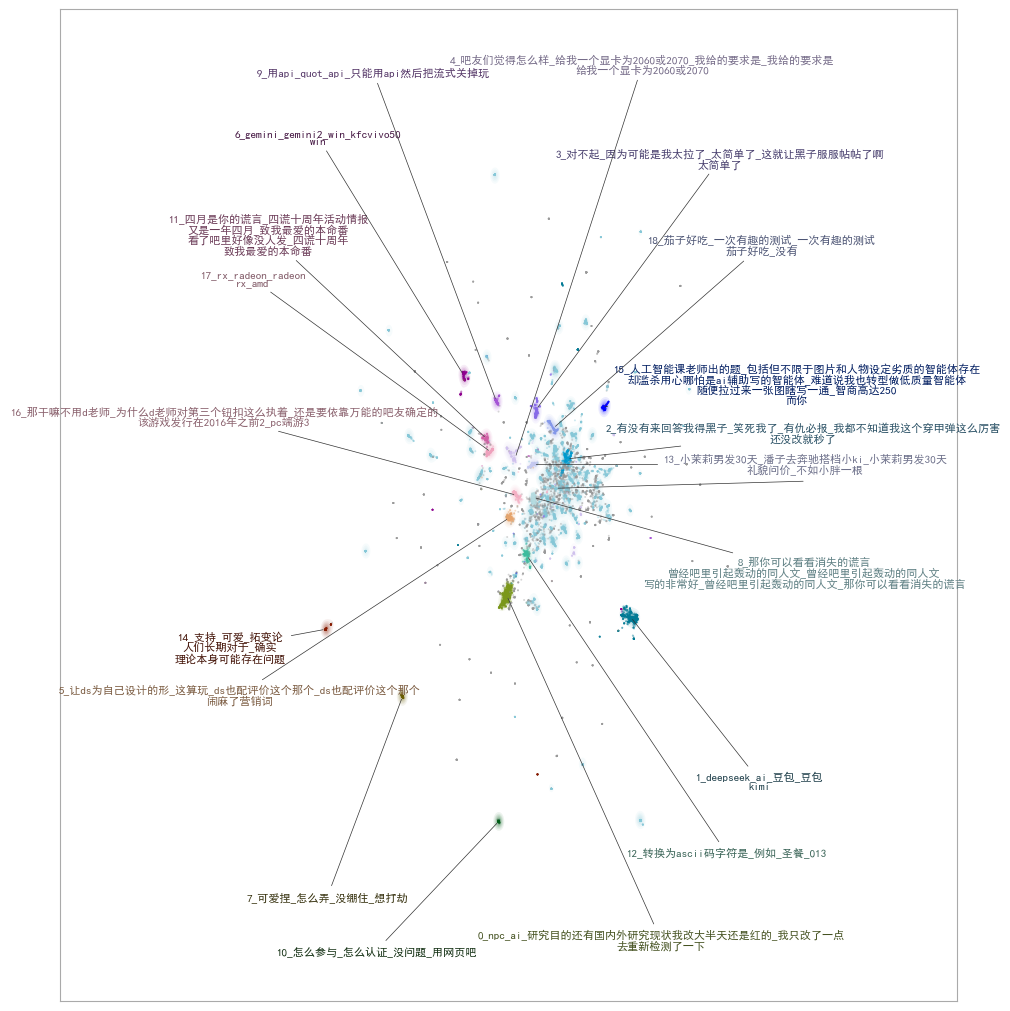

In [5]:
import datamapplot
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Source Han Sans SC']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

topic_counts = Counter(topics)
top_n = 20
top_topics = [t for t, _ in topic_counts.most_common(top_n)]
plot_labels = [
    all_labels[i] if topics[i] in top_topics else ''
    for i in range(len(all_labels))
]

# 创建图像并获取 Figure 对象
fig, ax = datamapplot.create_plot(
    reduced_embeddings,
    plot_labels,
    label_font_size=8,
    label_wrap_width=9,
    use_medoids=True,
    logo=None,
    logo_width=0.16,
    font_family="SimHei"
)
fig.savefig("tieba_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)
